# FinnSentiment

Neural Network implementation of sentiment analysis using **FinnSentiment** dataset from https://github.com/cynarr/sentiment-analysis/tree/master/data-raw

## 1.1 data preprocessing

In [1310]:
#import essential packages for the project
import numpy as np
import matplotlib.pyplot as plt

from string import punctuation

import nltk
from nltk.tokenize import word_tokenize

import torch

%matplotlib inline
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Windows\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [1311]:
# function to read data from a file
def process_data(datatype, language, label):
    '''
        input:
            - datatype: 'train' or 'test'
            - language: 'en'(English) or 'fi'(Finnish)
            - label: 'pos'(positive) or 'neg'(negative)
        output:
            - list of sentences
    '''
    filename = label + '_test.txt' if datatype=='test' else label + '.txt'
    filepath = 'data-raw/bin/' + language + '/' + datatype + '/' + filename

    with open(filepath, mode='r', encoding='utf8') as f:
        sentences = f.readlines()

    # -------------------------------------------------- data preprocessing  -------------------------------------------------- #
    processed = []
    
    for sentence in sentences:
        sentence = sentence.lower() # lowercase
        sentence = sentence.replace('\n','') # remove \n  

        words = word_tokenize(sentence) # tokenisation
        # remove non-alphabet characters and punctuations
        for word in words:
            if (word in list(punctuation)) or word.isalpha()==False: 
                words.remove(word)
                
        # append list of words of a sentence to data
        processed.append(words)
    # -------------------------------------------------- data preprocessing  -------------------------------------------------- #

    pol = 1 if label == 'pos' else 0 #polarity
    processed = [(sentence, pol) for sentence in processed]
    return processed

In [1312]:
# data preprocessing: get list of words for each sentence
train_pos = process_data('train','fi','pos')
train_neg = process_data('train','fi','neg')
test_pos = process_data('test','fi','pos')
test_neg = process_data('test','fi','neg')

print('preprocessing successful!')

preprocessing successful!


In [1313]:
train = train_pos + train_neg
test = test_pos + test_neg

In [1314]:
# shuffle data
import random

RANDOM_SEED = 916
random.seed(RANDOM_SEED)

train = train_pos + train_neg
test = test_pos + test_neg
random.shuffle(train)
random.shuffle(test)

In [1315]:
#validation set
split = int(0.9*len(train))
val = train[split::]
train = train[0:split]

In [1316]:
all = train + val + test
all[0:10]

[(['mistä', 'sinä', 'puhut'], 0),
 (['miten', 'oikein', 'sekaannuin', 'tuollaiseen', 'pummiin'], 0),
 (['hoidan', 'sen', 'heti'], 1),
 (['hän', 'pudotti', 'vanhanaikaisen', 'jakoavaimensa'], 0),
 (['hän', 'on', 'kuolemaisillaan'], 0),
 (['pelkureiden', 'säännöstö'], 0),
 (['tunnen', 'hänet', 'läpikotaisin'], 1),
 (['älä', 'tee', 'sitä'], 0),
 (['onpa', 'kaunis', 'mekko'], 1),
 (['jos',
   'haluat',
   'gablerin',
   'pysyvän',
   'hengissä',
   '-',
   'vakuuta',
   'hänelle',
   'että',
   'olet',
   'terve',
   'ja',
   'onnellinen'],
  0)]

In [1317]:
from collections import Counter

# corpus builder
corpus = sum([e[0] for e in all],[])
corpus = Counter(corpus)
print('The number of unique words is', len(corpus))

The number of unique words is 9770


In [1318]:
# encoder 
one_hot_encoder = {w:i+2 for i,w in enumerate(corpus)}
one_hot_encoder

{'mistä': 2,
 'sinä': 3,
 'puhut': 4,
 'miten': 5,
 'oikein': 6,
 'sekaannuin': 7,
 'tuollaiseen': 8,
 'pummiin': 9,
 'hoidan': 10,
 'sen': 11,
 'heti': 12,
 'hän': 13,
 'pudotti': 14,
 'vanhanaikaisen': 15,
 'jakoavaimensa': 16,
 'on': 17,
 'kuolemaisillaan': 18,
 'pelkureiden': 19,
 'säännöstö': 20,
 'tunnen': 21,
 'hänet': 22,
 'läpikotaisin': 23,
 'älä': 24,
 'tee': 25,
 'sitä': 26,
 'onpa': 27,
 'kaunis': 28,
 'mekko': 29,
 'jos': 30,
 'haluat': 31,
 'gablerin': 32,
 'pysyvän': 33,
 'hengissä': 34,
 '-': 35,
 'vakuuta': 36,
 'hänelle': 37,
 'että': 38,
 'olet': 39,
 'terve': 40,
 'ja': 41,
 'onnellinen': 42,
 'täällä': 43,
 'näyttää': 44,
 'erilaiselta': 45,
 'mies': 46,
 'osaa': 47,
 'hommansa': 48,
 'mitä': 49,
 'tämä': 50,
 'huolehdi': 51,
 'jota': 52,
 'olemme': 53,
 'odottaneet': 54,
 'hauska': 55,
 'humalassa': 56,
 'räjäytämme': 57,
 'auki': 58,
 'joku': 59,
 'heitti': 60,
 'rengasketjun': 61,
 'joka': 62,
 'osui': 63,
 'häntä': 64,
 'suuhun': 65,
 'haluatko': 66,
 'tanssia

In [1319]:
pad = 0
unk = 1

pad_token = '<pad>'
unk_token = '<unk>'

one_hot_encoder[pad_token] = pad
one_hot_encoder[unk_token] = unk

In [1320]:
length = [len(e[0]) for e in all]
maxlen = max(length)
print('The longest sentence has', maxlen, 'words')

The longest sentence has 25 words


In [1321]:
def padding_(data, max_len):
    padded = data

    for sentence,_ in data:
        l = len(sentence)
        if l <= max_len:
            for _ in range(0, max_len - l):
                sentence.append('<pad>')
    return padded


train_pad = padding_(train,maxlen)
val_pad = padding_(val,maxlen)
test_pad = padding_(test,maxlen)

In [1322]:
#encode train, val, test
def encode(data):
    encoded = []
    for sentence,pol in data:
        encoded_sentence = []
        for word in sentence:
            if word in corpus:
                encoded_sentence.append(one_hot_encoder[word])
            else:
                encoded_sentence.append(one_hot_encoder[unk_token])    
        encoded.append((encoded_sentence, pol))
    return encoded

In [1323]:
train_enc = encode(train_pad)
val_enc = encode(val_pad)
test_enc = encode(test_pad)

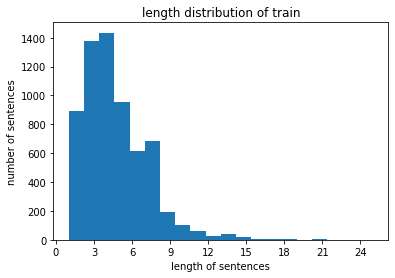

The Average Review length is 4.680877547845029
The Standard Deviation is 2


In [1324]:
# sentence length distribution
plt.title('length distribution of train')
plt.hist(length, bins=20)
plt.xlabel('length of sentences')
plt.ylabel('number of sentences')
plt.xticks(np.arange(0, 25, step=3))

plt.show()

print("The Average Review length is", np.mean(length))
print("The Standard Deviation is", round(np.std(length)))

In [1325]:
def to_tensor(data):
    sentence = [e[0] for e in data]
    polarity = [e[1] for e in data]

    tt = torch.tensor(sentence)
    pol_tt = torch.tensor(polarity)
    return tt, pol_tt

In [1326]:
train_tensor,train_pol_tensor = to_tensor(train_enc)
val_tensor,val_pol_tensor = to_tensor(train_enc)
test_tensor,test_pol_tensor = to_tensor(test_enc)

In [1327]:
train_tensor.size(), train_pol_tensor.size()

(torch.Size([5196, 25]), torch.Size([5196]))

In [1328]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

train_data = TensorDataset(train_tensor, train_pol_tensor)
val_data = TensorDataset(val_tensor,val_pol_tensor)
test_data = TensorDataset(test_tensor,test_pol_tensor)

# dataloaders
batch_size = 256

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

In [1329]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)


print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample output: \n', sample_y)

Sample input size:  torch.Size([256, 25])
Sample input: 
 tensor([[  2,   3,   4,  ...,   1,   1,   1],
        [  5,   6,   7,  ...,   1,   1,   1],
        [ 10,  11,  12,  ...,   1,   1,   1],
        ...,
        [501,  76, 790,  ...,   1,   1,   1],
        [792, 793,  26,  ...,   1,   1,   1],
        [542, 186, 372,  ...,   1,   1,   1]])
Sample output: 
 tensor([0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
        1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0

## 1.2 build model

In [1330]:
import torch.nn as nn

In [1331]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [1332]:
# model class
class SentimentRNN(nn.Module):
    def __init__(self, no_layers, vocab_size, hidden_dim, embedding_dim, drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
   
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
       
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
       
        # dropout layer
        self.dropout = nn.Dropout(0.3)
   
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
       
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
       
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
       
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
       
        # sigmoid function
        sig_out = self.sig(out)
       
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)


        sig_out = sig_out[:, -1] # get last batch of labels
       
        # return last sigmoid output and hidden state
        return sig_out, hidden
       
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden 

In [1333]:
# model class (self-implementation)
class lstm(nn.Module):
    def __init__(self, input_len, hidden_len, num_layers, output_len):
        super().__init__()
        self.input_len = input_len
        self.hidden_len = hidden_len
        self.num_layers = num_layers
        self.output_len = output_len
        self.lstm = nn.LSTM(input_len, hidden_len, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_len, output_len)

    def forward(self, x):
        h_0 = torch.zeros(1, batch_size, self.hidden_len)
        c_0 = torch.zeros(1, batch_size, self.hidden_len)
        out,_ = self.lstm(x, (h_0, c_0))
        out = self.fc()(out[:,-1,:])
        return out


In [1334]:
# hyperparameters
no_layers = 2
vocab_size = len(corpus) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers, vocab_size, hidden_dim, embedding_dim, drop_prob=0.5)

print(model)

SentimentRNN(
  (embedding): Embedding(9771, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [1335]:
input_len = embedding_dim
hidden_len = hidden_dim
num_layers = no_layers
output_len = output_dim

model = lstm(input_len, hidden_len, num_layers, output_len)
print(model)

lstm(
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


In [1336]:
# loss and optimization functions
lr=1e-4
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [1337]:
# loss and optimization functions
lr=1e-2
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def acc_(pred, label):
    a = torch.sum(pred == label)
    return a/batch_size 


## 1.3 train and validate

In [1338]:
# train the model
def train():
    pass

In [1339]:
# validate the result
def validate():
    pass

In [1340]:
epoch = 500

for i in range(epoch):
    
    model.train()
    for inputs, labels in train_loader:
        out = model(inputs)
        optimizer.zero_grad()
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
    
    model.eval()
    for inputs, labels in val_loader:
        output = model(inputs)
        optimizer.zero_grad()
        val_loss = criterion(out, labels)
        
        accuracy = acc_(output,labels)
        val_loss.backward()
        optimizer.step()
    
    if i % 50 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 
        print('accuracy: ', accuracy)
        print(50*'==')

RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors

In [ ]:
clip = 5
epochs = 5
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]


for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state
    h = model.init_hidden(batch_size)

    # -------------------------------- train --------------------------------
    for inputs, labels in train_loader:
       
        inputs, labels = inputs.to(device), labels.to(device)  
        h = tuple([each.data for each in h])
       
        model.zero_grad()
        output,h = model(inputs,h) 
       
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())

        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        
        nn.utils.clip_grad_norm_(model.parameters(), clip) #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        optimizer.step()

    # -------------------------------- validation --------------------------------   
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in val_loader:
        val_h = tuple([each.data for each in val_h])

        inputs, labels = inputs.to(device), labels.to(device)

        output, val_h = model(inputs, val_h)
        val_loss = criterion(output.squeeze(), labels.float())

        val_losses.append(val_loss.item())
        
        accuracy = acc(output,labels)
        val_acc += accuracy
           
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(val_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)

    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(50*'==')

AttributeError: 'lstm' object has no attribute 'init_hidden'

## 1.4. model evaluation visulisation

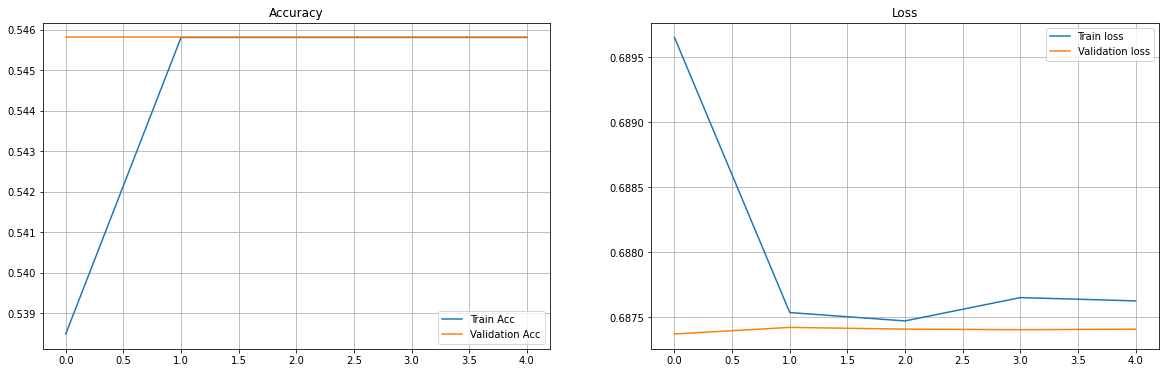

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
   
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()


plt.show()

## 1.5 testing and prediction